Solo Team: Kareem Hassani

Basically, we have this excel file of a Questionaire. First Let us import the file.

In [161]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from google.colab import files

uploaded = files.upload()


Saving 2024_PersonalityTraits_SurveyData.xls to 2024_PersonalityTraits_SurveyData (5).xls


Now that we have uploaded the excel file. We need to organize the data. Usually on VSCode We would have the Excel file's Path Name and extract the dataframe easily. However, on collab we do the following:

In [162]:
## Colab ##

ExcelPath = list(uploaded.keys())[0]
df = pd.read_excel(ExcelPath)

# VSCODE
#ExcelPath = r"C:\Users\Kareem Hassani\OneDrive\Desktop\College\Year Three\Fall\EECE 490\Hackathon\2024_PersonalityTraits_SurveyData.xls"
#df = pd.read_excel(ExcelPath)

print((df.head())) #this will print the first couple of row with a couple of columns

   Unnamed: 0   Sector  Last page  \
0           5  Private          5   
1          11  Private          5   
2          14  Private          5   
3          15  Private          5   
4          16  Private          5   

  Have you smoked at least one full tobacco cigarette (excluding e-cigarettes) once or more in the past 30 days?  \
0                                                Yes                                                               
1                                                Yes                                                               
2                                                Yes                                                               
3                                                Yes                                                               
4                                                Yes                                                               

  I see myself as someone who is extraverted, enthusiastic:  \
0                

The first column has no  column name so we have to exlude it and all the column's values. The columns are the features, of course. We will also organize the rows

In [164]:
df = df.iloc[:, 1:]
Features = list(df.columns) #The first column i unamed and looks meanigless. Take everything in front of it....
print(Features)
WithC0Rows = df.to_numpy().tolist() #including bad column
Rows = []
for row in WithC0Rows:
    Rows.append(row) #ignore first column


['Sector', 'Last page', 'Have you smoked at least one full tobacco cigarette (excluding e-cigarettes) once or more in the past 30 days?', 'I see myself as someone who is extraverted, enthusiastic:', 'I see myself as someone who is critical, quarrelsome:', 'I see myself as someone who is dependable, self-disciplined:', 'I see myself as someone who is anxious, easily upset:', 'I see myself as someone who is open to new experiences:', 'I see myself as someone who is reserved, quiet:', 'I see myself as someone who is sympathetic, warm:', 'I see myself as someone who is disorganized, careless:', 'I see myself as someone who is calm, emotionally stable:', 'I see myself as someone who is conventional, uncreative:', 'Do you find it difficult to refrain from smoking where it is forbidden (church, library, cinema, plane, etc...)?', 'How many cigarettes do you smoke each day?', 'Do you smoke more frequently during the first hours after waking up than during the rest of the day?\xa0', 'Do you smok

Basically, as you may have noticed, almost all of the values of data tuples are not discrete. They vary... This is a problem if we are to work with the dataset. WHich brings us to the first idea I had for this dataset, use PCA and GMM to categorize the  different clusters/types of smokers.

We need to first discretize the dataset. This is will be a challenge. We can - in a way - promt ourselves to discritize each UNIQUE value of a column's values. Say [-3-->3] with -3 is strognly disagrees and 3 is strongly agrees. Of course, we need to maintain a hashmap so that - for the same uniqque list of inputs - we don't prompoursleves to discretize it again.

The below is a function that does the above - pormpting the user. Of course, there may be better ways of doing this. One idea I had was sending each Unique List through OpenAI's API so that it will return a map of the discretized values in the key value pair. However, this would be expensive on large datasets. A better is to run GetGlobalMap once and save the values that I have entered for future use (instead of always going through this function). The function below is just for show.

In [165]:
GlobalMap = {}

def GetGlobalMap():
    for i in range(0, len(Features)):
        PossibleValues = df[f"{Features[i]}"].unique()
        print(f"Feature: {Features[i]}")
        print(f"Possible Values: {PossibleValues}")
        PossibleValues = tuple(sorted(filter(pd.notna, PossibleValues)))  # Filter out NaN and sort for consistency

        if PossibleValues not in GlobalMap:
            print("Need to manually set scalar")
            DiscreteMap = {}

            DefaultMapping = input("Enter 'D' to use default index-based mapping: ")

            if DefaultMapping == "D":
                DiscreteMap = {uv: idx for idx, uv in enumerate(PossibleValues)}
            else:
                for uv in PossibleValues:
                    Inpt = input(f"Enter scaled value (e.g., -6 to 6 with -6 being weakest) for '{uv}' in {Features[i]}: ")
                    Inpt = float(Inpt)  # Convert input to float
                    DiscreteMap[uv] = Inpt

            GlobalMap[PossibleValues] = DiscreteMap
        else:
            DiscreteMap = GlobalMap[PossibleValues]

    return GlobalMap  # Return after processing all features

#X = GetGlobalMap() ################# NO NEED TO RUN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1
#print(X)

In [ ]:
#print(X)

{(5,): {5: 0}, ('Yes',): {'Yes': 0}, ('Agree a little', 'Agree moderately', 'Agree strongly', 'Disagree a little', 'Disagree moderately', 'Disagree strongly', 'Neither agree nor disagree'): {'Agree a little': 1.0, 'Agree moderately': 2.0, 'Agree strongly': 3.0, 'Disagree a little': -1.0, 'Disagree moderately': -2.0, 'Disagree strongly': -3.0, 'Neither agree nor disagree': 0.0}, ('Agree a little', 'Agree moderately', 'Agree strongly', 'Disagree a little', 'Disagree moderately', 'Neither agree nor disagree'): {'Agree a little': 1.0, 'Agree moderately': 2.0, 'Agree strongly': 3.0, 'Disagree a little': -1.0, 'Disagree moderately': -2.0, 'Neither agree nor disagree': 0.0}, ('No', 'Yes'): {'No': 1.0, 'Yes': -1.0}, ('10 or less cigarettes/day', '11 to 20 cigarettes', '21 to 30 cigarettes', '31 cigarettes/day or more'): {'10 or less cigarettes/day': 10.0, '11 to 20 cigarettes': 20.0, '21 to 30 cigarettes': 30.0, '31 cigarettes/day or more': 50.0}, ('31 to 60 minutes', '6 to 30 minutes', 'After

The below is the saved state of the map I have created.

In [166]:
X = {(5,): {5: 0}, ('Yes',): {'Yes': 0}, ('Agree a little', 'Agree moderately', 'Agree strongly', 'Disagree a little', 'Disagree moderately', 'Disagree strongly', 'Neither agree nor disagree'): {'Agree a little': 1.0, 'Agree moderately': 2.0, 'Agree strongly': 3.0, 'Disagree a little': -1.0, 'Disagree moderately': -2.0, 'Disagree strongly': -3.0, 'Neither agree nor disagree': 0.0}, ('Agree a little', 'Agree moderately', 'Agree strongly', 'Disagree a little', 'Disagree moderately', 'Neither agree nor disagree'): {'Agree a little': 1.0, 'Agree moderately': 2.0, 'Agree strongly': 3.0, 'Disagree a little': -1.0, 'Disagree moderately': -2.0, 'Neither agree nor disagree': 0.0}, ('No', 'Yes'): {'No': 1.0, 'Yes': -1.0}, ('10 or less cigarettes/day', '11 to 20 cigarettes', '21 to 30 cigarettes', '31 cigarettes/day or more'): {'10 or less cigarettes/day': 10.0, '11 to 20 cigarettes': 20.0, '21 to 30 cigarettes': 30.0, '31 cigarettes/day or more': 50.0}, ('31 to 60 minutes', '6 to 30 minutes', 'After 60 minutes', 'Within 5 minutes'): {'31 to 60 minutes': 2.0, '6 to 30 minutes': 3.0, 'After 60 minutes': 1.0, 'Within 5 minutes': 4.0}, ('All others', 'The first one in the morning'): {'All others': 0, 'The first one in the morning': 1}, (9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 189, 2016): {9: 9.0, 10: 10.0, 13: 13.0, 14: 14.0, 15: 15.0, 16: 16.0, 17: 17.0, 18: 18.0, 19: 19.0, 20: 20.0, 21: 21.0, 22: 22.0, 23: 23.0, 24: 24.0, 25: 25.0, 27: 27.0, 189: 20.0, 2016: 20.0}, ('The number of cigarettes I smoke per day has decreased', 'The number of cigarettes I smoke per day has increased', 'The number of cigarettes I smoke per day has remained the same'): {'The number of cigarettes I smoke per day has decreased': 0, 'The number of cigarettes I smoke per day has increased': 1, 'The number of cigarettes I smoke per day has remained the same': 2}, ('.', 'Ab', 'Allor', 'Allure', 'Camel', 'Camel blue', 'Camel rolling tobacco', 'Camel, Golden Virginia', 'Cedars', 'Cedars - Malboro', 'Ceders', 'Cederz', 'Cohiba', 'Daviddoff', 'Davidof', 'Davidoff', 'Davidoff \nMarlboro red', 'Domingo', 'Dunhill', 'Dunhill switch.', 'Gitanes', 'Golden verginia', 'Heets', 'Heets\nMarlboro Gold\nParliament', 'Heets-marlboro', 'Heets/ previously Davidoff classic', "I don't smoke cigarettes but I smoke IQOS.", 'Iqos', 'Kent', 'Kent silver, Marlboro', 'Malboro', 'Malboro Touch', 'Malborow', 'Mallboro', 'Manitou', 'Marbolo', 'Marlboro', 'Marlboro \nWinston', 'Marlboro Flavor Mix', 'Marlboro Gold', 'Marlboro Gold / Marlboro Medium', 'Marlboro double fusion 4', 'Marlboro fine touch', 'Marlboro gitane', 'Marlboro gold', 'Marlboro light\nMarlboro touch', 'Marlboro light blue', 'Marlboro or any other philip morris cigaret', 'Marlboro red', 'Marlboro red soft', 'Marlboro reds, cedars silver', 'Marlboro touch', 'Marlboro-ceedars', 'Marlboro-gold', 'More', 'No preference in brands or nicotine magnitude', 'Rolling tobacco golden virginia', 'Winston', 'Winston Red Packet', 'camel yellow', 'cederz', 'cohiba', 'davidoff', 'davidoff and marlboro', 'davidoff gold', 'davidoff or marlboro', 'davidoff red', 'davidoff slim', 'gauloises', 'iqos purple wave heets', 'kent', 'lucky strike', 'malboro blue', 'marbolo red paper', 'marlboro', 'marlboro Gold', 'marlboro and heets', 'marlboro gold', 'marlboro lights', 'marlboro or iqos', 'marlboro or kent', 'marlboro touch', 'marlboro, iqos', 'parliament / cohiba / winston blue', 'اوسكار', 'دوفيدوف', 'مارلبورو', 'مالبورو'): {'.': 0, 'Ab': 1, 'Allor': 2, 'Allure': 3, 'Camel': 4, 'Camel blue': 5, 'Camel rolling tobacco': 6, 'Camel, Golden Virginia': 7, 'Cedars': 8, 'Cedars - Malboro': 9, 'Ceders': 10, 'Cederz': 11, 'Cohiba': 12, 'Daviddoff': 13, 'Davidof': 14, 'Davidoff': 15, 'Davidoff \nMarlboro red': 16, 'Domingo': 17, 'Dunhill': 18, 'Dunhill switch.': 19, 'Gitanes': 20, 'Golden verginia': 21, 'Heets': 22, 'Heets\nMarlboro Gold\nParliament': 23, 'Heets-marlboro': 24, 'Heets/ previously Davidoff classic': 25, "I don't smoke cigarettes but I smoke IQOS.": 26, 'Iqos': 27, 'Kent': 28, 'Kent silver, Marlboro': 29, 'Malboro': 30, 'Malboro Touch': 31, 'Malborow': 32, 'Mallboro': 33, 'Manitou': 34, 'Marbolo': 35, 'Marlboro': 36, 'Marlboro \nWinston': 37, 'Marlboro Flavor Mix': 38, 'Marlboro Gold': 39, 'Marlboro Gold / Marlboro Medium': 40, 'Marlboro double fusion 4': 41, 'Marlboro fine touch': 42, 'Marlboro gitane': 43, 'Marlboro gold': 44, 'Marlboro light\nMarlboro touch': 45, 'Marlboro light blue': 46, 'Marlboro or any other philip morris cigaret': 47, 'Marlboro red': 48, 'Marlboro red soft': 49, 'Marlboro reds, cedars silver': 50, 'Marlboro touch': 51, 'Marlboro-ceedars': 52, 'Marlboro-gold': 53, 'More': 54, 'No preference in brands or nicotine magnitude': 55, 'Rolling tobacco golden virginia': 56, 'Winston': 57, 'Winston Red Packet': 58, 'camel yellow': 59, 'cederz': 60, 'cohiba': 61, 'davidoff': 62, 'davidoff and marlboro': 63, 'davidoff gold': 64, 'davidoff or marlboro': 65, 'davidoff red': 66, 'davidoff slim': 67, 'gauloises': 68, 'iqos purple wave heets': 69, 'kent': 70, 'lucky strike': 71, 'malboro blue': 72, 'marbolo red paper': 73, 'marlboro': 74, 'marlboro Gold': 75, 'marlboro and heets': 76, 'marlboro gold': 77, 'marlboro lights': 78, 'marlboro or iqos': 79, 'marlboro or kent': 80, 'marlboro touch': 81, 'marlboro, iqos': 82, 'parliament / cohiba / winston blue': 83, 'اوسكار': 84, 'دوفيدوف': 85, 'مارلبورو': 86, 'مالبورو': 87}, ('Ab', 'Allure', 'Any, nothing specific i never buy a pack', 'Calle+ IQOS+ Redfield rolling tabaco', 'Camel', 'Camel blue', 'Camel rolling tobacco', 'Ccedars', 'Cedars', 'Cedars, rolling local tobacco', 'Ceders', 'Ceders Blue', 'Cederz', 'Ceedars-heets', 'Cidar', 'Ciders silver. Kent Silver. Depends on what I can afford.', 'Cudars slim', 'Daviddoff', 'Davidoff', 'Davidoff evolve', 'Domingo', 'Dunhill', 'Gitane', 'Gitanes', 'Golden Virginia', 'Golden verginia', 'Heats', 'Heets', 'Heets (IQOS)', 'Heets by Iqos', 'Heets silver', 'I dont use any, i smoke casually and take one from my friends', 'IQOS', 'IQOS HEETS AMBER', 'Iqos', 'Kent', 'Kent Blue', 'Kent Silver', 'Malboro', 'Malboro craft', 'Malborow', 'Mallboro', 'Marlbolo', 'Marlboro', 'Marlboro Gold', 'Marlboro blue', 'Marlboro fine touch', 'Marlboro red', 'Marlboro red soft', 'Marlboro reds and sometimes cedars silver', 'Marlboro touch', 'Marlboro-touch', 'More', 'Parliament Azra2', 'Rolling tobacco golden virginia', 'Sometimes malboro sometimes ceedars', 'Stanley tobbaco', 'Suderes', 'Winston', 'Winston Red Packet', 'Winston/ davidoff', 'cedar', 'cedars', 'cedars and laf', 'cedars super slim silver', 'ceders', 'cederz', 'ceedars', 'cohiba', 'davidoff', 'davidoff and marlboro', 'davidoff gold', 'davidoff slim', 'gauloises', 'i stayed smoking winston but now i switched to using iqos', 'iqos', 'iqos purple wave heets', 'kent', 'marbolo red paper', 'marlboro', 'marlboro craft', 'marlboro fine touch', 'marlboro gold', 'marlboro gold and iqos', 'marlboro gold or lights', 'marlboro lights', 'marlboro or iqos', 'marlboro silver blue', 'marlboro touch', 'marlbroro blue', 'none', 'stanley', 'اوسكار', 'دوفيدوف', 'سيدر', 'سيدرز'): {'Ab': 0, 'Allure': 1, 'Any, nothing specific i never buy a pack': 2, 'Calle+ IQOS+ Redfield rolling tabaco': 3, 'Camel': 4, 'Camel blue': 5, 'Camel rolling tobacco': 6, 'Ccedars': 7, 'Cedars': 8, 'Cedars, rolling local tobacco': 9, 'Ceders': 10, 'Ceders Blue': 11, 'Cederz': 12, 'Ceedars-heets': 13, 'Cidar': 14, 'Ciders silver. Kent Silver. Depends on what I can afford.': 15, 'Cudars slim': 16, 'Daviddoff': 17, 'Davidoff': 18, 'Davidoff evolve': 19, 'Domingo': 20, 'Dunhill': 21, 'Gitane': 22, 'Gitanes': 23, 'Golden Virginia': 24, 'Golden verginia': 25, 'Heats': 26, 'Heets': 27, 'Heets (IQOS)': 28, 'Heets by Iqos': 29, 'Heets silver': 30, 'I dont use any, i smoke casually and take one from my friends': 31, 'IQOS': 32, 'IQOS HEETS AMBER': 33, 'Iqos': 34, 'Kent': 35, 'Kent Blue': 36, 'Kent Silver': 37, 'Malboro': 38, 'Malboro craft': 39, 'Malborow': 40, 'Mallboro': 41, 'Marlbolo': 42, 'Marlboro': 43, 'Marlboro Gold': 44, 'Marlboro blue': 45, 'Marlboro fine touch': 46, 'Marlboro red': 47, 'Marlboro red soft': 48, 'Marlboro reds and sometimes cedars silver': 49, 'Marlboro touch': 50, 'Marlboro-touch': 51, 'More': 52, 'Parliament Azra2': 53, 'Rolling tobacco golden virginia': 54, 'Sometimes malboro sometimes ceedars': 55, 'Stanley tobbaco': 56, 'Suderes': 57, 'Winston': 58, 'Winston Red Packet': 59, 'Winston/ davidoff': 60, 'cedar': 61, 'cedars': 62, 'cedars and laf': 63, 'cedars super slim silver': 64, 'ceders': 65, 'cederz': 66, 'ceedars': 67, 'cohiba': 68, 'davidoff': 69, 'davidoff and marlboro': 70, 'davidoff gold': 71, 'davidoff slim': 72, 'gauloises': 73, 'i stayed smoking winston but now i switched to using iqos': 74, 'iqos': 75, 'iqos purple wave heets': 76, 'kent': 77, 'marbolo red paper': 78, 'marlboro': 79, 'marlboro craft': 80, 'marlboro fine touch': 81, 'marlboro gold': 82, 'marlboro gold and iqos': 83, 'marlboro gold or lights': 84, 'marlboro lights': 85, 'marlboro or iqos': 86, 'marlboro silver blue': 87, 'marlboro touch': 88, 'marlbroro blue': 89, 'none': 90, 'stanley': 91, 'اوسكار': 92, 'دوفيدوف': 93, 'سيدر': 94, 'سيدرز': 95}, ('No, I am currently using my favorite or preferred cigarette brand(s)', 'Yes, I am currently using a cheaper alternative', 'Yes, I am currently using a more expensive alternative'): {'No, I am currently using my favorite or preferred cigarette brand(s)': 0, 'Yes, I am currently using a cheaper alternative': 1, 'Yes, I am currently using a more expensive alternative': 2}, ('Female', 'Male'): {'Female': -1.0, 'Male': 1.0}, (18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30): {18: 18.0, 19: 19.0, 20: 20.0, 21: 21.0, 22: 22.0, 23: 23.0, 24: 24.0, 25: 25.0, 26: 26.0, 27: 27.0, 28: 28.0, 29: 29.0, 30: 30.0}, ('Baalbeck - Hermel', 'Beirut', 'Beqaa', 'Keserwan - Jbeil', 'Mount Lebanon', 'Nabatieh', 'North Lebanon', 'South Lebanon'): {'Baalbeck - Hermel': 0, 'Beirut': 1, 'Beqaa': 2, 'Keserwan - Jbeil': 3, 'Mount Lebanon': 4, 'Nabatieh': 5, 'North Lebanon': 6, 'South Lebanon': 7}, ("Bachelor's degree (BA/BS)", 'Graduate degree (MA/MS)', 'High school degree or equivalent (e.g. GED)', "Incomplete bachelor's degree", 'Incomplete graduate degree', 'Less than high school', 'Post-graduate degree (PhD, MD, or other)'): {"Bachelor's degree (BA/BS)": 0, 'Graduate degree (MA/MS)': 1, 'High school degree or equivalent (e.g. GED)': 2, "Incomplete bachelor's degree": 3, 'Incomplete graduate degree': 4, 'Less than high school': 5, 'Post-graduate degree (PhD, MD, or other)': 6}, ('Business owner', 'Employee; full-time', 'Employee; part-time', 'Homemaker', 'Other, please specify', 'Student only', 'Student with a part-time or full-time job', 'Unemployed (but seeking employment)'): {'Business owner': 0, 'Employee; full-time': 1, 'Employee; part-time': 2, 'Homemaker': 3, 'Other, please specify': 4, 'Student only': 5, 'Student with a part-time or full-time job': 6, 'Unemployed (but seeking employment)': 7}, ('Student and business owner', 'اتمنى ان اتوقف عن التدخين لكن الامر صعب', 'حاولت التوقف عن التدخين عدة مرات لكن لم استطع', 'طالب مع عمل حر', 'طالبة ربة منزل و تعمل من المنزل', 'كل الشكر ❤️'): {'Student and business owner': 0, 'اتمنى ان اتوقف عن التدخين لكن الامر صعب': 1, 'حاولت التوقف عن التدخين عدة مرات لكن لم استطع': 2, 'طالب مع عمل حر': 3, 'طالبة ربة منزل و تعمل من المنزل': 4, 'كل الشكر ❤️': 5}, ('Divorced/Separated', 'Engaged', 'Married', 'Other, please specify', 'Single'): {'Divorced/Separated': 0, 'Engaged': 1, 'Married': 2, 'Other, please specify': 3, 'Single': 4}, ('....', 'I have a boyfriend', 'In a relationship', 'Long-term Relationship', 'Planning to get engaged', 'Single be2is', 'Taken , love relationship', 'in a relationship', 'in relationship', 'relationship', 'غير متزوج'): {'....': 0, 'I have a boyfriend': 1, 'In a relationship': 2, 'Long-term Relationship': 3, 'Planning to get engaged': 4, 'Single be2is': 5, 'Taken , love relationship': 6, 'in a relationship': 7, 'in relationship': 8, 'relationship': 9, 'غير متزوج': 10}, (0, 1, 2, 3, 4, 5): {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}, ('Investment', 'Job', 'Other, please specify', 'Own business income', 'Parents'): {'Investment': 0, 'Job': 1, 'Other, please specify': 2, 'Own business income': 3, 'Parents': 4}, ('Crypto', 'Scholarship', 'Scholarshsip', 'Stipend from a graduate degree scholarship', 'savings', 'scholarship', 'الزوج و عمل بمدخول بسيط', 'زراعة', 'زوجي', 'عمل دوام جزئي ومن الآباء', 'مساعدة مالية من الخارج'): {'Crypto': 0, 'Scholarship': 1, 'Scholarshsip': 2, 'Stipend from a graduate degree scholarship': 3, 'savings': 4, 'scholarship': 5, 'الزوج و عمل بمدخول بسيط': 6, 'زراعة': 7, 'زوجي': 8, 'عمل دوام جزئي ومن الآباء': 9, 'مساعدة مالية من الخارج': 10}, ('Fully in Lebanese Lira', 'Fully in US Dollars', 'Mixed', 'Other, please specify'): {'Fully in Lebanese Lira': 0, 'Fully in US Dollars': 1, 'Mixed': 2, 'Other, please specify': 3}, ('Euro', 'My family lives in libya. Receives money in Libyan dinars.', 'No income, living off savings', 'none'): {'Euro': 0, 'My family lives in libya. Receives money in Libyan dinars.': 1, 'No income, living off savings': 2, 'none': 3}, ('Between 1 and 4 million L.L', 'Between 12 and 16 million L.L', 'Between 16 and 20 million L.L', 'Between 4 and 8 million L.L', 'Between 8 and 12 million L.L', "I don't know", 'I prefer not to say', 'Less than 1 million L.L', 'More than 20 million L.L'): {'Between 1 and 4 million L.L': 2.5, 'Between 12 and 16 million L.L': 14.0, 'Between 16 and 20 million L.L': 18.0, 'Between 4 and 8 million L.L': 6.0, 'Between 8 and 12 million L.L': 10.0, "I don't know": 0.0, 'I prefer not to say': 0.0, 'Less than 1 million L.L': 1.0, 'More than 20 million L.L': 20.0}, ('Extremely high: covers a wide range of luxury items', 'High: completely covers necessities with a few luxury items', 'Low: barely covers basic needs for a month', 'Medium: covers all basic needs', 'Very low income: does not cover basic needs for a month'): {'Extremely high: covers a wide range of luxury items': 100.0, 'High: completely covers necessities with a few luxury items': 70.0, 'Low: barely covers basic needs for a month': 20.0, 'Medium: covers all basic needs': 50.0, 'Very low income: does not cover basic needs for a month': 10.0}, (0, 1, 2, 3, 4, 5, 6, 7, 8): {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}, ('Extremely', 'Moderately', 'Not at all', 'Slightly', 'Very'): {'Extremely': 100.0, 'Moderately': 70.0, 'Not at all': 0.0, 'Slightly': 20.0, 'Very': 90.0}, ('Every day or at least 5 times every week', 'Never', 'Often or at least 3 days every week', 'Sometimes or a few days every month'): {'Every day or at least 5 times every week': 7.0, 'Never': 0.0, 'Often or at least 3 days every week': 3.0, 'Sometimes or a few days every month': 2.0}, ('Between 1 hour and 2 hours', 'Between 2 and 3 hours', 'Between 3 and 4 hours', "I don't use any social media platforms", 'Less than 1 hour', 'More than 4 hours'): {'Between 1 hour and 2 hours': 0, 'Between 2 and 3 hours': 1, 'Between 3 and 4 hours': 2, "I don't use any social media platforms": 3, 'Less than 1 hour': 4, 'More than 4 hours': 5}, ('Constantly', 'Frequently', 'Never', 'Occasionally', 'Rarely'): {'Constantly': 100.0, 'Frequently': 70.0, 'Never': 0.0, 'Occasionally': 30.0, 'Rarely': 10.0}, ('Employed', 'Unemployed'): {'Employed': -1.0, 'Unemployed': 1.0}}


For the time being, let us naively take all the features in our clustering. However, I dropped the features that have null values - for simplicity

In [167]:
df2 = df.iloc[:, 1:]
GlobalMap = X
# Assuming `Features` contains the column names from the DataFrame after dropping the first column
Features = list(df2.columns)
# Apply the GlobalMap to map values for each column
for feature in Features:
    PossibleValues = tuple(sorted(filter(pd.notna, df2[feature].unique())))  # Filter and sort unique values for consistency
    if PossibleValues in GlobalMap:
        # Map the column values using the corresponding mapping in GlobalMap
        df2[feature] = df2[feature].map(GlobalMap[PossibleValues])
    else:
        print(f"No mapping found for feature '{feature}' with values: {PossibleValues}")

# Display the modified DataFrame
print("Updated DataFrame:")

#print(df.isnull().sum())
df3 = df2.drop(columns=["What is your current employment status? [Comment]",
                    "What is your current marital status? [Comment]",
                    "What is your main source of income? [Comment]",
                    "What type of income or financial support does your household receive? [Comment]",
                    "What is your favorite or preferred cigarette brand(s) if you were able to access it?",
                    "I see myself as someone who is critical, quarrelsome:"
                    ])
print(df3.head())

Updated DataFrame:
   Last page  \
0          0   
1          0   
2          0   
3          0   
4          0   

   Have you smoked at least one full tobacco cigarette (excluding e-cigarettes) once or more in the past 30 days?  \
0                                                  0                                                                
1                                                  0                                                                
2                                                  0                                                                
3                                                  0                                                                
4                                                  0                                                                

   I see myself as someone who is extraverted, enthusiastic:  \
0                                                3.0           
1                                                2.0 

In [170]:
print("Disrete DataFrame:")
print(df3.head())

Disrete DataFrame:
   Last page  \
0          0   
1          0   
2          0   
3          0   
4          0   

   Have you smoked at least one full tobacco cigarette (excluding e-cigarettes) once or more in the past 30 days?  \
0                                                  0                                                                
1                                                  0                                                                
2                                                  0                                                                
3                                                  0                                                                
4                                                  0                                                                

   I see myself as someone who is extraverted, enthusiastic:  \
0                                                3.0           
1                                                2.0 

Now that we have discretized the dataset. We can finally work.

In [177]:
pca = PCA(n_components=2)
columns_with_nan = df3.columns[df3.isna().any()]
print("Columns with NaN values:", columns_with_nan)

df4 = df3.drop(columns=[

                    'What cigarette brand(s) are you currently using?'
                    ])



X_pca = pca.fit_transform(df4)

Columns with NaN values: Index(['What cigarette brand(s) are you currently using?'], dtype='object')


Assuming  we don't know the number of clusters, we need a way to predict the optimal number of clusters. We can use the elbow method for kmeans clustering first to determine the 'elbow'.

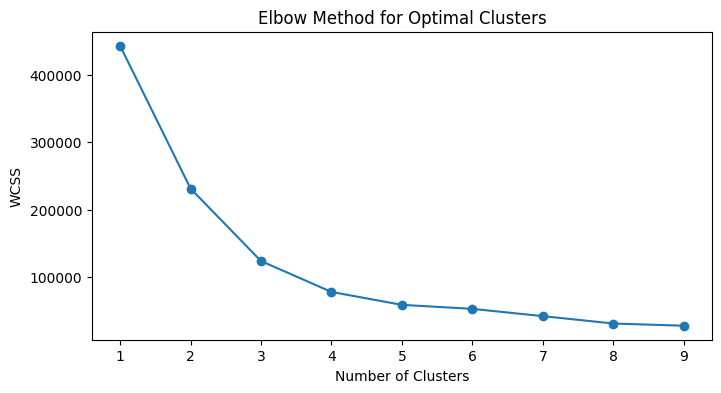

In [178]:
from sklearn.cluster import KMeans

wcss = []

for n in range(1, 10):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(X_Pca)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Clusters')
plt.show()


It appears that the elbow method tells us that there are 3 clusters. Let us go with 3 intially.

In [179]:
GMM = GaussianMixture(n_components=3, random_state=42)
GMM.fit(X_pca)

ClustersPred = GMM.predict(X_pca)
MeansMatrix = GMM.means_
CovarianceMatrix = GMM.covariances_

We will recyclee the plotting code from Lab 4 to display the clusters

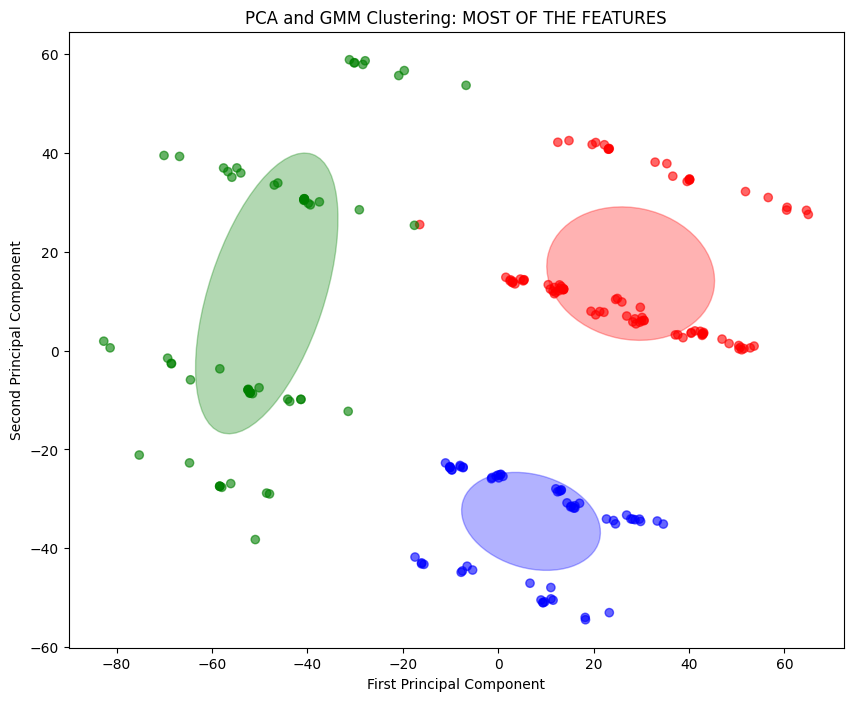

Number of clusters: 3


In [180]:
Colors = ["b", "g", "r", "c", "m", "y", "k", "navy", "coral", "slategray"]
plt.figure(figsize=(10, 8))
ClusterColors = [Colors[label % len(Colors)] for label in ClustersPred]

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=ClusterColors, alpha=0.6)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA and GMM Clustering: MOST OF THE FEATURES")

ax = plt.gca()
for i, (mean, covariance) in enumerate(zip(MeansMatrix, CovarianceMatrix)):
    eigenvalues, eigenvectors = np.linalg.eigh(covariance)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]
    angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]) * 180 / np.pi
    width, height = 2 * np.sqrt(eigenvalues)
    ellipse = Ellipse(mean, width=width, height=height, angle=angle,
                      color=Colors[i % len(Colors)], alpha=0.3)
    ax.add_patch(ellipse)

plt.show()

num_clusters = len(np.unique(ClustersPred))
print(f"Number of clusters: {num_clusters}")

As we can see, some of the PCA points are closly grouped together, possibly because of low varince between the inputs. If we are to hand select the most important features when it comes to smoking, we will get a better result.

In [194]:
threshold = 1    #This method filters out the low variance features increase threshold for less features
Sel = VarianceThreshold(threshold=threshold)
f_reduced = pd.DataFrame(Sel.fit_transform(df4), columns=df4.columns[Sel.get_support()])
#print(" Remaining shape:", f_reduced.shape)

#Let us just hand select it.....

selected_features = [
    "How many cigarettes do you smoke each day?",



    "I see myself as someone who is anxious, easily upset:",
    "I see myself as someone who is calm, emotionally stable:",
    "How old are you?",




    "How would you describe your current income sufficiency?",
    "How often do you feel stressed?",
    "How often do you exercise?"
]
selected_features = [feature.strip().replace('\xa0', '') for feature in selected_features]

# Drop missing features
selected_features = [feature for feature in selected_features if feature in df.columns]

df5 = df4[selected_features]


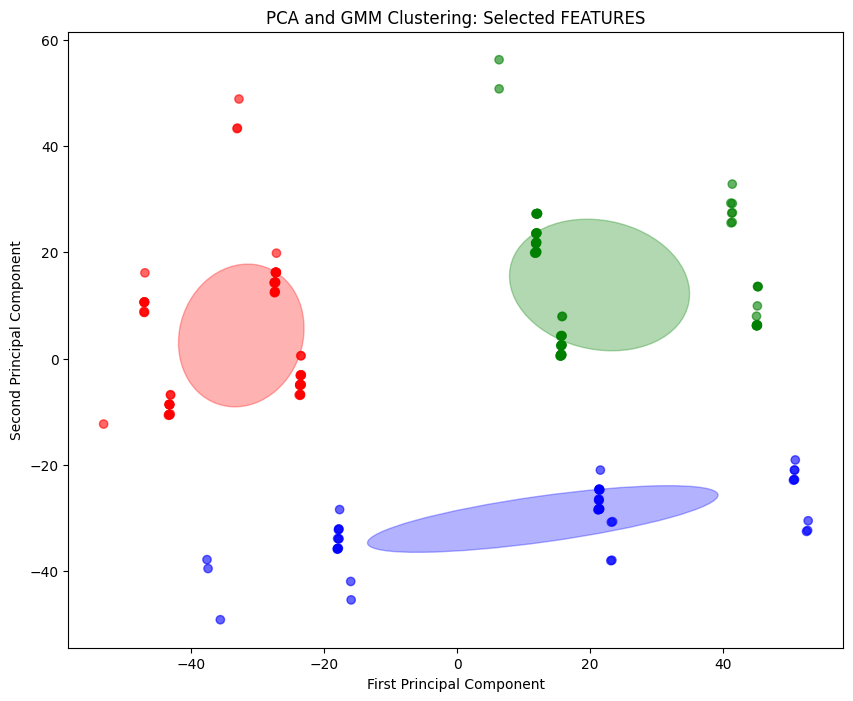

Number of clusters: 3


In [195]:
pca = PCA(n_components=2)
# Use f instead of df for PCA
X_pca = pca.fit_transform(df5)

# Apply Gaussian Mixture Model (GMM) for clustering
GMM = GaussianMixture(n_components=3, random_state=42)
GMM.fit(X_pca)

ClustersPred = GMM.predict(X_pca)
MeansMatrix = GMM.means_
CovarianceMatrix = GMM.covariances_

# Visualization
Colors = ["b", "g", "r", "c", "m", "y", "k", "navy", "coral", "slategray"]
plt.figure(figsize=(10, 8))
ClusterColors = [Colors[label % len(Colors)] for label in ClustersPred]

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=ClusterColors, alpha=0.6)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA and GMM Clustering: Selected FEATURES")

ax = plt.gca()
for i, (mean, covariance) in enumerate(zip(MeansMatrix, CovarianceMatrix)):
    eigenvalues, eigenvectors = np.linalg.eigh(covariance)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]
    angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]) * 180 / np.pi
    width, height = 2 * np.sqrt(eigenvalues)
    ellipse = Ellipse(mean, width=width, height=height, angle=angle,
                      color=Colors[i % len(Colors)], alpha=0.3)
    ax.add_patch(ellipse)

plt.show()

num_clusters = len(np.unique(ClustersPred))
print(f"Number of clusters: {num_clusters}")

I looked up toher methods to see the best type of cluster: The Bayesian Information Criterion (BIC) is a statistical measure used to evaluate and compare models, particularly in the context of clustering or regression. It assesses the goodness of fit of a model while penalizing for complexity to prevent overfitting.

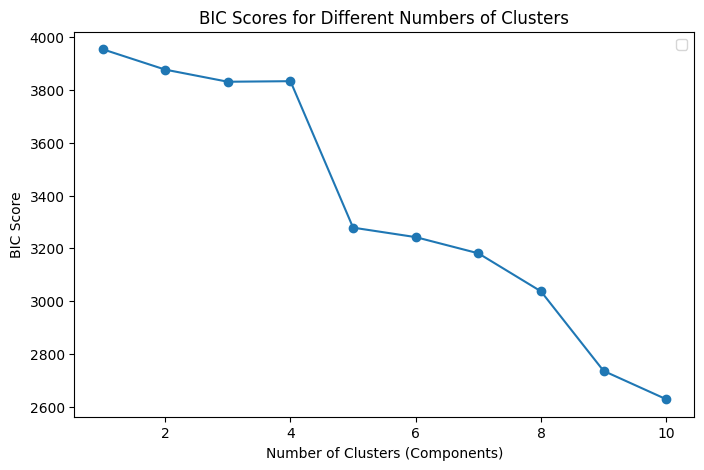

In [203]:
n_components_range = range(1, 11)  # Try 1 to 10 clusters
bics = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_pca)
    bics.append(gmm.bic(X_pca))

# Identify the best number of clusters based on the lowest BIC
best_n = n_components_range[np.argmin(bics)]

plt.figure(figsize=(8,5))
plt.plot(n_components_range, bics, marker='o')
plt.xlabel('Number of Clusters (Components)')
plt.ylabel('BIC Score')
plt.title('BIC Scores for Different Numbers of Clusters')

plt.legend()
plt.show()

As said in the literature, 5 clusters is around the best. The BIC peak shows a 4 cluster optimization (to baalnce between overfitting and underfitting). Let us continue the rest of our research based on the actual literature: 5 clusters. The below plots the 5 clusters.

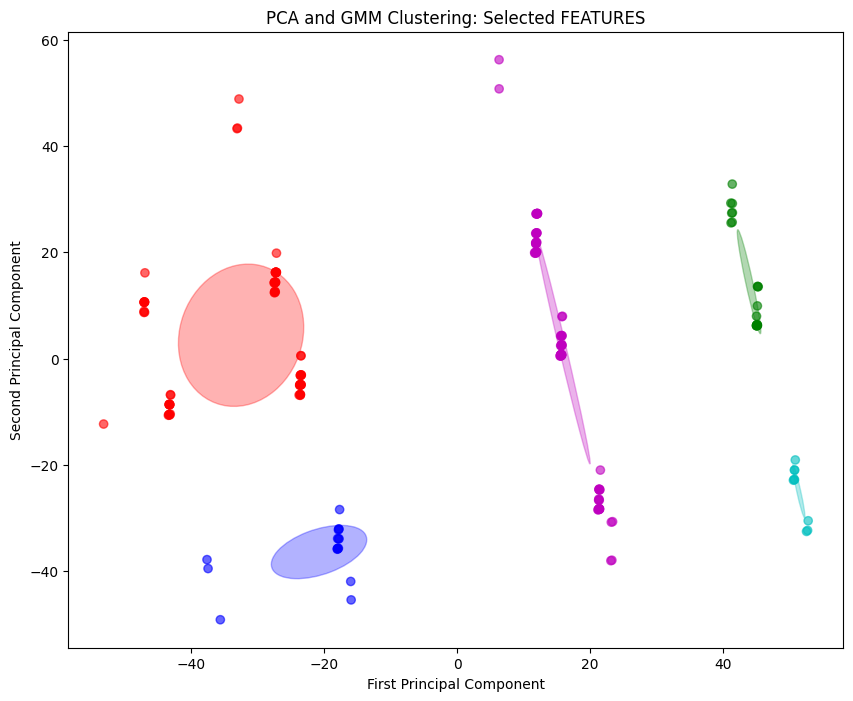

Number of clusters: 5


In [204]:
pca = PCA(n_components=2)
# Use f instead of df for PCA
X_pca = pca.fit_transform(df5)

# Apply Gaussian Mixture Model (GMM) for clustering
GMM = GaussianMixture(n_components=5, random_state=42)
GMM.fit(X_pca)

ClustersPred = GMM.predict(X_pca)
MeansMatrix = GMM.means_
CovarianceMatrix = GMM.covariances_

# Visualization
Colors = ["b", "g", "r", "c", "m", "y", "k", "navy", "coral", "slategray"]
plt.figure(figsize=(10, 8))
ClusterColors = [Colors[label % len(Colors)] for label in ClustersPred]

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=ClusterColors, alpha=0.6)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA and GMM Clustering: Selected FEATURES")

ax = plt.gca()
for i, (mean, covariance) in enumerate(zip(MeansMatrix, CovarianceMatrix)):
    eigenvalues, eigenvectors = np.linalg.eigh(covariance)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]
    angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]) * 180 / np.pi
    width, height = 2 * np.sqrt(eigenvalues)
    ellipse = Ellipse(mean, width=width, height=height, angle=angle,
                      color=Colors[i % len(Colors)], alpha=0.3)
    ax.add_patch(ellipse)

plt.show()

num_clusters = len(np.unique(ClustersPred))
print(f"Number of clusters: {num_clusters}")

This looks better defined. If we are to take 10 clusters as the BIC says we should we get an eveen better visualization. The below is just an example however we will continue will the 5 cluster model.

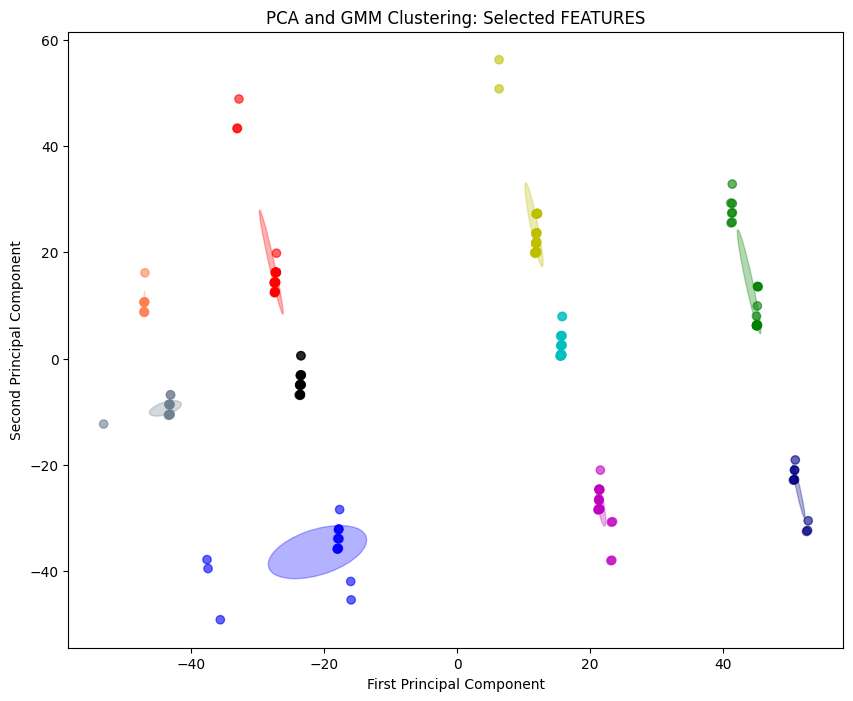

Number of clusters: 10


In [205]:
pca = PCA(n_components=2)
# Use f instead of df for PCA
X_pca = pca.fit_transform(df5)

# Apply Gaussian Mixture Model (GMM) for clustering
GMM = GaussianMixture(n_components=10, random_state=42)
GMM.fit(X_pca)

ClustersPred = GMM.predict(X_pca)
MeansMatrix = GMM.means_
CovarianceMatrix = GMM.covariances_

# Visualization
Colors = ["b", "g", "r", "c", "m", "y", "k", "navy", "coral", "slategray"]
plt.figure(figsize=(10, 8))
ClusterColors = [Colors[label % len(Colors)] for label in ClustersPred]

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=ClusterColors, alpha=0.6)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA and GMM Clustering: Selected FEATURES")

ax = plt.gca()
for i, (mean, covariance) in enumerate(zip(MeansMatrix, CovarianceMatrix)):
    eigenvalues, eigenvectors = np.linalg.eigh(covariance)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]
    angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]) * 180 / np.pi
    width, height = 2 * np.sqrt(eigenvalues)
    ellipse = Ellipse(mean, width=width, height=height, angle=angle,
                      color=Colors[i % len(Colors)], alpha=0.3)
    ax.add_patch(ellipse)

plt.show()

num_clusters = len(np.unique(ClustersPred))
print(f"Number of clusters: {num_clusters}")

Now, let us try another mean of dimentiaonlity reduction: Autoencoders!

In [208]:
#df5 is the df to go
import torch.nn as nn
import torch.nn.functional as F
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

Intialze and train the AE!

In [215]:
import torch.optim as optim
import torch

input_dim = df5.shape[1]
data_tensor = torch.tensor(df5.values, dtype=torch.float32)

dataset = TensorDataset(data_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

latent_dim = 5
autoencoder = AutoEncoder(input_dim=input_dim, latent_dim=latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=1e-5)



In [225]:
epochs = 30
autoencoder.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in loader:
        xb = batch[0]
        optimizer.zero_grad()
        xb_recon = autoencoder(xb)
        loss = criterion(xb_recon, xb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/30], Loss: 6.2258
Epoch [2/30], Loss: 6.1864
Epoch [3/30], Loss: 6.1629
Epoch [4/30], Loss: 6.3887
Epoch [5/30], Loss: 6.3480
Epoch [6/30], Loss: 6.2064
Epoch [7/30], Loss: 5.9112
Epoch [8/30], Loss: 5.7657
Epoch [9/30], Loss: 5.6472
Epoch [10/30], Loss: 5.4618
Epoch [11/30], Loss: 5.3552
Epoch [12/30], Loss: 5.0652
Epoch [13/30], Loss: 4.7707
Epoch [14/30], Loss: 4.5208
Epoch [15/30], Loss: 4.1897
Epoch [16/30], Loss: 3.6978
Epoch [17/30], Loss: 3.2212
Epoch [18/30], Loss: 2.4726
Epoch [19/30], Loss: 1.9603
Epoch [20/30], Loss: 1.6354
Epoch [21/30], Loss: 1.4690
Epoch [22/30], Loss: 1.3885
Epoch [23/30], Loss: 1.3480
Epoch [24/30], Loss: 1.3175
Epoch [25/30], Loss: 1.2402
Epoch [26/30], Loss: 1.2195
Epoch [27/30], Loss: 1.2453
Epoch [28/30], Loss: 1.2660
Epoch [29/30], Loss: 1.2869
Epoch [30/30], Loss: 1.2756


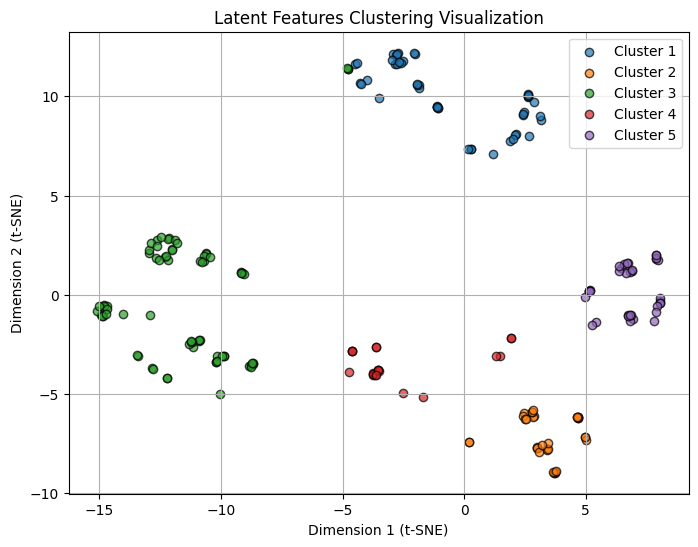

In [226]:
# Extract Latent Features
autoencoder.eval()
with torch.no_grad():
    latent_features = autoencoder.encode(data_tensor).numpy()

# Scale Latent Features
latent_features_scaled = StandardScaler().fit_transform(latent_features)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latent_features_scaled)

plt.figure(figsize=(8, 6))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
for i in range(num_clusters):
    cluster_points = latent_2d[cluster_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                label=f'Cluster {i + 1}', c=colors[i % len(colors)], alpha=0.7, edgecolor='k')

plt.title("Latent Features Clustering Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2 ")
plt.legend()
plt.grid(True)
plt.show()

Now that we have explored good models that cluster. Let us explore the possi